In [1]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape, Concatenate, Flatten, Lambda
from keras.models import Model
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.losses import binary_crossentropy, kullback_leibler_divergence
from keras import backend as K
from struct import unpack
import matplotlib.pyplot as plt
import json
import glob
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
import numpy as np
from keras.optimizers import Adam
from io import BytesIO
import PIL
from PIL import ImageDraw
from keras.utils import get_file
from IPython.display import clear_output, Image, display, HTML

In [2]:
BASE_PATH = 'https://storage.googleapis.com/quickdraw_dataset/full/binary/'
path = get_file('cat', BASE_PATH + 'cat.bin')

19578880/19571324 [==============================] - 4s 0us/step

In [3]:
def load_icons(path, train_size=0.85):
    x = []
    with open(path, 'rb') as f:
        while True:
            img = PIL.Image.new('L', (32, 32), 'white')
            draw = ImageDraw.Draw(img)
            header = f.read(15)
            if len(header) != 15:
                break
            strokes, = unpack('H', f.read(2))
            for i in range(strokes):
                n_points, = unpack('H', f.read(2))
                fmt = str(n_points) + 'B'
                read_scaled = lambda: (p // 8 for 
                                       p in unpack(fmt, f.read(n_points)))
                points = [*zip(read_scaled(), read_scaled())]
                draw.line(points, fill=0, width=2)
            img = img_to_array(img)
            x.append(img)
    x = np.asarray(x) / 255
    return train_test_split(x, train_size=train_size)


x_train, x_test = load_icons(path)
x_train.shape, x_test.shape

((104721, 32, 32, 1), (18481, 32, 32, 1))

In [4]:
def create_autoencoder():
    input_img = Input(shape=(32, 32, 1))

    channels = 2
    x = input_img
    for i in range(4):
        channels *= 2
        left = Conv2D(channels, (3, 3), activation='relu', padding='same')(x)
        right = Conv2D(channels, (2, 2), activation='relu', padding='same')(x)
        conc = Concatenate()([left, right])
        x = MaxPooling2D((2, 2), padding='same')(conc)

    x = Dense(channels)(x)

    for i in range(4):
        x = Conv2D(channels, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        channels //= 2
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    return autoencoder

autoencoder = create_autoencoder()
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 4)    40          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 4)    20          input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 32, 32, 8)    0           conv2d[0][0]                     
                                                                 conv2d_1[0][0]               

In [5]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/100
819/819 [==============================] - 5s 6ms/step - loss: 0.6793 - val_loss: 0.6690

In [6]:
cols = 25
idx = np.random.randint(x_test.shape[0], size=cols)
sample = x_test[idx]
decoded_imgs = autoencoder.predict(sample)
decoded_imgs.shape

(25, 32, 32, 1)

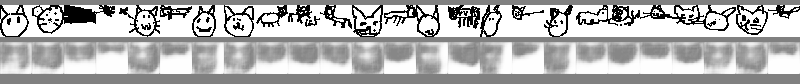

In [7]:
def decode_img(tile, factor=1.0):
    tile = tile.reshape(tile.shape[:-1])
    tile = np.clip(tile * 255, 0, 255)
    return PIL.Image.fromarray(tile)
    

overview = PIL.Image.new('RGB', (cols * 32, 64 + 20), (128, 128, 128))
for idx in range(cols):
    overview.paste(decode_img(sample[idx]), (idx * 32, 5))
    overview.paste(decode_img(decoded_imgs[idx]), (idx * 32, 42))
f = BytesIO()
overview.save(f, 'png')
display(Image(data=f.getvalue()))



In [8]:
batch_size = 250
latent_space_depth = 64

def sample_z(args):
    z_mean, z_log_var = args
    eps = K.random_normal(shape=(batch_size, latent_space_depth), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * eps


In [9]:
def VariationalAutoEncoder(num_pixels):
    
    input_img = Input(shape=(32, 32, 1))

    channels = 4
    x = input_img
    for i in range(5):
        left = Conv2D(channels, (3, 3), activation='relu', padding='same')(x)
        right = Conv2D(channels, (2, 2), activation='relu', padding='same')(x)
        conc = Concatenate()([left, right])
        x = MaxPooling2D((2, 2), padding='same')(conc)
        channels *= 2

    x = Dense(channels)(x)
    encoder_hidden = Flatten()(x)

    z_mean = Dense(latent_space_depth, activation='linear')(encoder_hidden)
    z_log_var = Dense(latent_space_depth, activation='linear')(encoder_hidden)
    
    def KL_loss(y_true, y_pred):
        return 0.0001 * K.sum(K.exp(z_log_var) + K.square(z_mean) - 1 - z_log_var, axis=1)

    def reconstruction_loss(y_true, y_pred):
        y_true = K.batch_flatten(y_true)
        y_pred = K.batch_flatten(y_pred)
        return binary_crossentropy(y_true, y_pred)

    def total_loss(y_true, y_pred):
        return reconstruction_loss(y_true, y_pred) + KL_loss(y_true, y_pred)

    z = Lambda(sample_z, output_shape=(latent_space_depth, ))([z_mean, z_log_var])
    decoder_in = Input(shape=(latent_space_depth,))

    d_x = Reshape((1, 1, latent_space_depth))(decoder_in)
    e_x = Reshape((1, 1, latent_space_depth))(z)
    for i in range(5):
        conv = Conv2D(channels, (3, 3), activation='relu', padding='same')
        upsampling = UpSampling2D((2, 2))
        d_x = conv(d_x)
        d_x = upsampling(d_x)
        e_x = conv(e_x)
        e_x = upsampling(e_x)
        channels //= 2

    final_conv = Conv2D(1, (3, 3), activation='sigmoid', padding='same')
    auto_decoded = final_conv(e_x)
    decoder_out = final_conv(d_x)
    
    decoder = Model(decoder_in, decoder_out)    
    
    auto_encoder = Model(input_img, auto_decoded)

    auto_encoder.compile(optimizer=Adam(lr=0.001), 
                         loss=total_loss,
                         metrics=[KL_loss, reconstruction_loss])
    
    return auto_encoder, decoder

variational_auto_encoder, variational_decoder = VariationalAutoEncoder(x_train.shape[1])
variational_auto_encoder.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 32, 32, 4)    40          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 32, 32, 4)    20          input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 32, 32, 8)    0           conv2d_13[0][0]                  
                                                                 conv2d_14[0][0]            

In [10]:
x_train_2 = x_train[:-(x_train.shape[0] % batch_size),:,: :]
x_test_2 = x_test[:-(x_test.shape[0] % batch_size),:,: :]
x_train_2.shape, x_test_2.shape

((104500, 32, 32, 1), (18250, 32, 32, 1))

In [11]:
variational_auto_encoder.fit(x_train_2, x_train_2, verbose=1, 
                 batch_size=batch_size, epochs=100,
                 validation_data=(x_test_2, x_test_2))

Epoch 1/100


_SymbolicException: Inputs to eager execution function cannot be Keras symbolic tensors, but found [<tf.Tensor 'dense_3/Identity:0' shape=(None, 64) dtype=float32>, <tf.Tensor 'dense_2/Identity:0' shape=(None, 64) dtype=float32>]

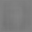

In [12]:
random_number = np.asarray([[np.random.normal() 
                            for _ in range(latent_space_depth)]])
img_width, img_height = 32, 32
def decode_img(a):
    a = np.clip(a * 256, 0, 255).astype('uint8')
    return PIL.Image.fromarray(a)

decode_img(variational_decoder.predict(random_number).reshape(img_width, img_height))


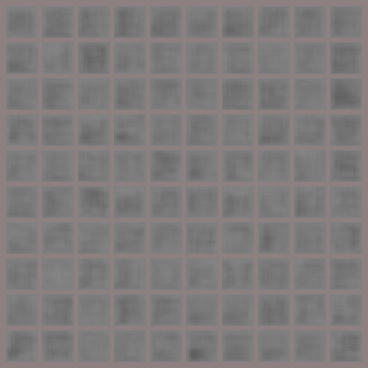

In [13]:
num_cells = 10
img_width = img_height = 32
overview = PIL.Image.new('RGB', 
                         (num_cells * (img_width + 4) + 8, 
                          num_cells * (img_height + 4) + 8), 
                         (140, 128, 128))

for x in range(num_cells):
    for y in range(num_cells):
        vec = np.asarray([[np.random.normal() 
                            for _ in range(latent_space_depth)]])
        decoded = variational_decoder.predict(vec)
        img = decode_img(decoded.reshape(img_width, img_height))
        overview.paste(img, (x * (img_width + 4) + 6, y * (img_height + 4) + 6))
overview

In [14]:
decoded.shape

(1, 32, 32, 1)

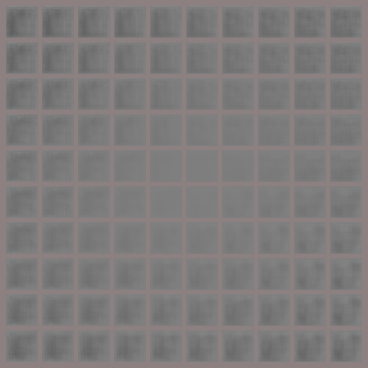

In [15]:
num_cells = 10

overview = PIL.Image.new('RGB', 
                         (num_cells * (img_width + 4) + 8, 
                          num_cells * (img_height + 4) + 8), 
                         (140, 128, 128))
for x in range(num_cells):
    for y in range(num_cells):
        vec = np.asarray([[ - (i % 2) * (x - 4.5) / 3 + ((i + 1) % 2) * (y - 4.5) / 3
                            for i in range(latent_space_depth)]])
        decoded = variational_decoder.predict(vec)
        img = decode_img(decoded.reshape(img_width, img_height))
        overview.paste(img, (x * (img_width + 4) + 6, y * (img_height + 4) + 6))
overview